### Import for days!
Let's pull all of the libraries we'll need  for the project

In [25]:
# will this ever be used... the world will never know
import tensorflow as tf

import math

# scrape wiki plaintext
import wikipedia

# to view word freq dist
import matplotlib.pyplot
import tkinter

# store the articles so we don't annoy wikipedia (TODO)
# (might change to database storage later)
import _pickle as cPickle

# trying database storage :)!
import sqlite3

# make pretty progress bars
from tqdm import tnrange, tqdm_notebook
from time import sleep

# commonly used words...
import re
import os.path
import urllib.request

from stop_words import get_stop_words
import nltk

from nltk.corpus import stopwords

### Let's get a list of common words and put them in one list/set

__Todo__
* Try Different sizes of the set (only top 1,000 stop words?)

In [2]:
nltk.download("stopwords")
nltk.download("punkt")

test = stopwords.words('english')

common_words = get_stop_words(language='english', cache=True)

fn = '10k_common.txt'

# wow, so ethical!
if os.path.isfile(fn):
    print("already downloaded the common words list")
    myfile = open(fn, 'r')
    most_common = [line for line in myfile.readlines()]
else:
    print('Let me download that common word list file for you!')
    url = 'https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english-usa.txt'
    urllib.request.urlretrieve(url, filename=fn)
    myfile = open(fn, 'r')
    most_common = [line.strip() for line in myfile.readlines()]
   
# Awesome, concat_list contains all of the unique common words

concat_list = list(set(s.lower().strip() for s in test + common_words + most_common))

[nltk_data] Downloading package stopwords to /home/robert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/robert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
already downloaded the common words list


### Now let's download a wiki article

__TO DO:__
* make a local article caching system

In [3]:
my_topic = "statistics"

article = wikipedia.page(title=my_topic,  auto_suggest=True, redirect=True, preload=False)

# article.content is text of info on the page
# article.link is a list of links
# for more info go here: https://pypi.python.org/pypi/wikipedia/

print("\n===================\nSuccessfully downloaded wiki article(",\
      my_topic ,  ")\n===================\n __SAMPLE__:\n",article.content[0:100],"...")


Successfully downloaded wiki article( statistics )
 __SAMPLE__:
 Statistics is a branch of mathematics dealing with the collection, analysis, interpretation, present ...


### Do some processesing on the article

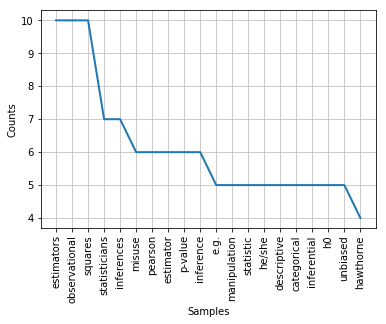


The top 20 uncommon words in the article on statistics are: 

('estimators', 10) 

('observational', 10) 

('squares', 10) 

('statisticians', 7) 

('inferences', 7) 

('p-value', 6) 

('misuse', 6) 

('pearson', 6) 

('inference', 6) 

('estimator', 6) 

('manipulation', 5) 

('unbiased', 5) 

('categorical', 5) 

('e.g.', 5) 

('statistic', 5) 

('descriptive', 5) 

('he/she', 5) 

('inferential', 5) 

('h0', 5) 

('bayesian', 4) 



In [4]:
tokens = nltk.word_tokenize(article.content)

must_contain_some_letters = re.compile("[a-zA-Z]+") # assuming corpus is latin alphabet (can update this assumption later)

words = [w.lower() for w in tokens]

# remove "words" that are only comprised of symbols and numbers only
words = list(filter(must_contain_some_letters.match, words))

# remove stop words
words = [w for w in words if w not in concat_list]


fd = nltk.FreqDist(words) 
n = 20
fd.plot(n, cumulative=False) 



# sorts the most frequent words
top_n_best_words_omg = []
for w in set(words):
    top_n_best_words_omg.append((w, words.count(w)))

top_n_best_words_omg.sort(key=lambda x: x[1], reverse=True)
# sort by the second element in the tuple

print("\n===================\nThe top", n ,"uncommon words in the article on" , my_topic, "are: \n===================\n")
for i in range(n):
    print(top_n_best_words_omg[i],"\n")


### Found a pretrained model called Glove on the internets (it's a very large word embedding model)

Simply put, word embeddings are numeric vector representations of words.

An example of this would be -- let the word "apple" be represented by the vector [1,0] and let every other word be represented by [0,1].

Although this is a word embedding, clearly, we can do better.

To read more about how Glove is fit to the data ;) go to [stanford ...'s website](https://nlp.stanford.edu/projects/glove/)


### GLOVE IS HUGE (~6gig text file)

So we're going to store it in an sqlite3 database!

__TODO__:
* write helper functions for database: enter (unique) data, extract data


In [5]:
# Database helper function
def table_exists(file_name, table_name):
    connection = sqlite3.connect(file_name)
    cur = connection.cursor()
    table_name = (table_name,)
    cur.execute('SELECT COUNT(*) from sqlite_master where type = \'table\' and name = ? ', table_name )
    result = cur.fetchone()
    connection.close()
    return result[0] == 1

In [6]:
# table information

sqlite_file = 'word_embedding_project.sqlite'

# table info must be a list of tuples containing column name and type

table1_name = 'glove_word_embeddings'
table1_info = [('word','VARCHAR(50)')\
              ,('embedding','VARCHAR(1500)')]

table2_name = 'wiki_articles'
table2_info = [('title','content')]

In [7]:

def create_table(file_name, table_name, list_of_tuple_column_name_type):
    if table_exists(file_name,table_name):
        print("table \'{}\' already exists, carrying on".format(table_name))
    else :
        connection = sqlite3.connect(file_name)
        c = connection.cursor()
        #print("------------------\nopened...", table_name)
        
        exe = 'CREATE TABLE ' + table_name + ' (' + ', '.join([i[0] +\
            ' ' +  i[1] for i in list_of_tuple_column_name_type]) + ' )'

        #print('\n :: sending SQL :: ' + exe + '\n')     
        
        c.execute('{}'.format(exe) )
        connection.close()
        #print("closed...", table_name, "\n------------------\n")

def get_column_names(file_name,table_name):
        connection = sqlite3.connect(file_name)
        c = connection.cursor()
        #print("------------------\nopened table:", table_name)
        
        exe = 'PRAGMA TABLE_INFO({})'.format(table_name)
        
        #print('\n :: sending SQL :: ' + exe + '\n')     
        c.execute('{}'.format(exe) )
        # result is a tuple, result[1] contains the table name
        names = [result[1] for result in c.fetchall()]
        
        connection.close()
        #print("closed table: ", table_name , "\n------------------\n")
        return names
        
def insert_data(file_name,table_name,list_of_tuple_data,\
                 unique_column_name):
        connection = sqlite3.connect(file_name)
        c = connection.cursor()
        #print("------------------\nopened...", connection)
        # somewhere in here we will check to see that the data is unique
        column_names = get_column_names(file_name,table_name)
        index_of_unique_column = column_names.index(unique_column_name)
        check_this_data = [i[index_of_unique_column] for i in list_of_tuple_data]
        
        my_unique_data = get_unique(file_name,table_name,check_this_data,unique_column_name)
        
        #print(my_unique_data)
        
        #add_these contains the unique entries that we'll add to the database!
        add_these = [i for i in list_of_tuple_data if my_unique_data.count(i[index_of_unique_column]) == 1]
        
        list_of_tuple_data = add_these
        
        if len(add_these) > 0:
            num_question_marks = len(list_of_tuple_data[0])
            exe = 'INSERT INTO ' + table_name + ' VALUES (' +\
            ','.join(['?' for i in range(num_question_marks)]) + ')'

            #print('\n :: sending SQL :: ' + exe + '\n')     

            c.executemany('{}'.format(exe),list_of_tuple_data )
            connection.commit()
        else:
            print("nothing new to add :(")
        
        connection.close()
        #print("closed...\n------------------\n", table_name)
        

def get_unique(file_name,table_name,list_of_data, unique_column):
        unique_list_of_tuple_data = []
        
        connection = sqlite3.connect(file_name)
        c = connection.cursor()
        
        for i in list_of_data:
            exe = 'SELECT count(*) FROM ' + table_name + ' WHERE ' + unique_column + ' = \'' + i +'\''
            #print('\n :: sending SQL :: ' + exe + '\n') 
            c.execute('{}'.format(exe))
            if c.fetchone()[0] > 0 :
                print("The data:\'"  + i + "\' already exists in the database")
            else :
                #print("Adding data: ", i , " to database")
                unique_list_of_tuple_data.append(i) 
        
        connection.close()
        return unique_list_of_tuple_data

def print_stored(file_name,table_name):
        connection = sqlite3.connect(file_name)
        c = connection.cursor()
        #print("------------------\nopened...", connection)

        exe = 'SELECT * FROM ' + table_name 
        #print('\n :: sending SQL :: ' + exe + '\n')     
        
        for row in c.execute('{}'.format(exe)):
            print(row)
        
        connection.close()
        #print("closed...\n------------------\n", table_name
        



In [32]:

create_table(sqlite_file,table1_name,table1_info)

create_table(sqlite_file,table2_name,table2_info)


insert_data(sqlite_file,table1_name,[('test_word1','embedding_00001')\
                                    ,('test_word2','embedding_00002')\
                                    ,('test_word3','embedding_00003')],\
           'word')

#print_stored(sqlite_file,table1_name)

# get_unique(sqlite_file,table1_name,['test_word1','test_word2','test_word_3'],unique_column='word')

num_lines = None

table 'glove_word_embeddings' already exists, carrying on
table 'wiki_articles' already exists, carrying on
The data:'test_word1' already exists in the database
The data:'test_word2' already exists in the database
The data:'test_word3' already exists in the database
nothing new to add :(


__TODO__
* extract the embeddings of the common words dataset
* do tsne on the embeddings


## Now that we have some database helper functions, let's insert the glove embeddings into the database

In [82]:
import linecache
import re

batch_size = 100 # insert this many words at a time into the database (play around with different numbers)
file_name = 'tail.txt'
error_file = 'errors.txt'

# regex to match word/embedding
# tested on regex101.com
# ^(?P<word>[\w.]+)(?P<embedding>[-.\s\d]+)$
word = re.compile(r"^(?P<word>[\w.]+)")
embedding = re.compile("\s[-.\s\d]+")
num_lines = sum(1 for line in open(file_name))

loops = math.ceil(num_lines/batch_size)
for i in tqdm_notebook(range(loops),desc='working through files' ):
    for off_set in range(batch_size):
        line_num = (100*(i))+off_set + 1;
        
        if line_num > num_lines:
            break
        else:
            my_line = linecache.getline(file_name,line_num)
            m = word.match(my_line)
            my_word = m.group(0)
            my_embed = my_line[m.end()+1:]
            
            embedding.match(my_line)
                    
            number = len(my_embed.split())
            if number != 300:
                print(line_num,' : \nWord:', my_word, '\nMy embed:', my_embed )


300
300
300
300
300
300
300
301
8  : 
Word: z 
My embed: 28 0.7344 -0.33641 0.26918 0.41843 -0.189 0.2802 0.23875 -0.12879 -0.15797 -1.2841 0.33532 -0.31047 0.72732 0.31546 0.71186 0.19048 -0.042019 -0.074581 0.45085 0.44498 -0.1904 -0.3766 0.49905 -0.028839 -0.20881 0.01066 0.25383 -0.0041936 -0.38734 0.32464 0.55693 -0.83097 -0.03571 0.24106 -0.6569 0.57372 -0.56636 -0.34669 0.23249 0.001781 0.19858 -0.074999 0.046491 -0.32702 -0.22864 0.2175 0.89353 -0.35827 -0.41881 -0.6151 -0.049783 -0.68134 -0.11981 -0.40551 0.96578 0.26983 -0.31023 -0.65689 0.065648 0.026246 -0.69145 -0.21135 0.31764 -1.0328 -0.64371 0.2877 -0.089071 -0.54376 -0.14109 -0.17937 0.35235 -0.55115 -0.55691 0.21101 -0.21912 -0.51552 -0.24145 0.2055 -0.37466 -0.25949 -0.84854 -0.060169 0.45496 -0.086216 -0.012816 0.69526 1.2326 -0.30129 -0.60421 -0.27917 -0.031972 -1.0298 0.13614 0.51755 -0.40155 0.91298 0.08289 0.74463 0.87894 0.35653 -0.33584 0.89456 -0.19836 -0.20825 -1.1171 -0.74503 -0.10777 -0.45809 -0.13718 -0.2